In [1]:
#Import packages
#Base packages
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

#Figure setting
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=300
plt.rcParams['figure.figsize']=[8,6]

#Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#scGAE modules
from scgae import SCGAE
from preprocessing import *
from utils import *
from losses import *
from clustering import *

In [2]:
#Load data
count = np.array(pd.read_csv("Data/demo_data_norm.csv", index_col=0, sep="\t"))
idents = np.array(pd.read_csv("Data/idents.csv", index_col=0, sep="\t")).reshape(-1,)

In [3]:
#Build model
adj, adj_n = get_adj(count)
model = SCGAE(count, adj=adj, adj_n=adj_n)

#Pre-training
model.pre_train(epochs = 120)

Epoch 10  X_rec_loss: 0.5993458   A_rec_loss: 0.034996815
Epoch 20  X_rec_loss: 0.584432   A_rec_loss: 0.035
Epoch 30  X_rec_loss: 0.57613   A_rec_loss: 0.035
Epoch 40  X_rec_loss: 0.56800276   A_rec_loss: 0.035
Epoch 50  X_rec_loss: 0.556896   A_rec_loss: 0.035
Epoch 60  X_rec_loss: 0.5414283   A_rec_loss: 0.035
Epoch 70  X_rec_loss: 0.5210207   A_rec_loss: 0.035
Epoch 80  X_rec_loss: 0.49663574   A_rec_loss: 0.035
Epoch 90  X_rec_loss: 0.47026715   A_rec_loss: 0.035
Epoch 100  X_rec_loss: 0.4470885   A_rec_loss: 0.035
Epoch 110  X_rec_loss: 0.42376757   A_rec_loss: 0.035
Epoch 120  X_rec_loss: 0.40446118   A_rec_loss: 0.035000987
Pre_train Finish!


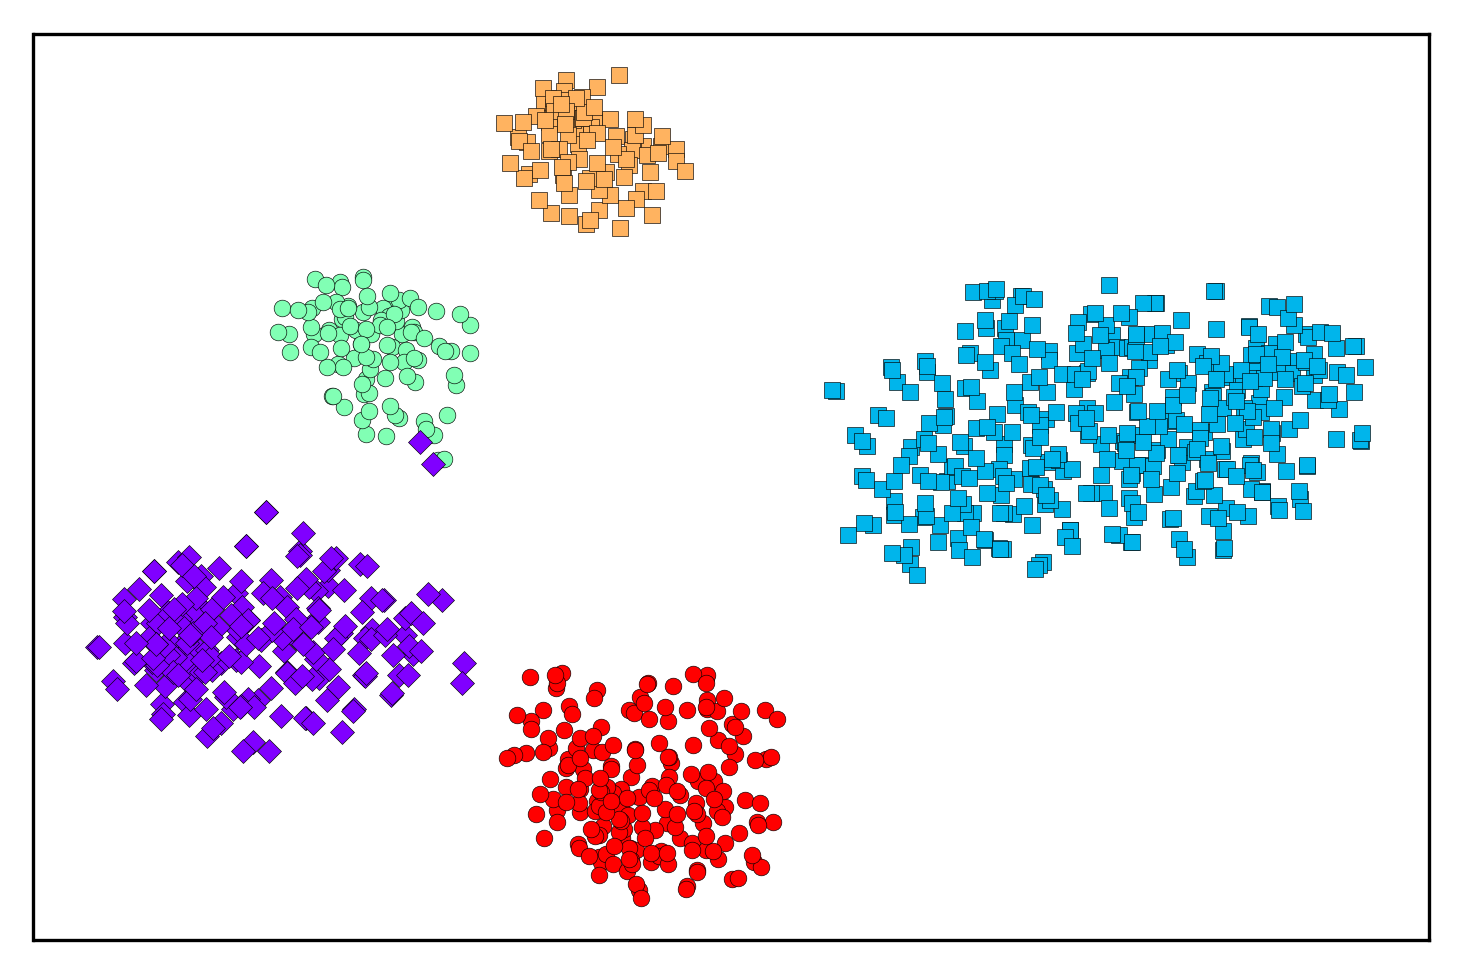

In [4]:
#Genertate latent embedding and visualization
Y = model.embedding(count, adj_n)
Y2 = dotsne(Y)
myscatter(Y2, idents)

In [5]:
#For data with cluster structure, do the following steps for clustering-training
#Initialize cluster centers by Louvain clustering
from clustering import louvain
cl_model = louvain(level=0.5)
cl_model.update(Y, adj_mat=adj)
labels = cl_model.labels
centers = computeCentroids(Y, labels)

In [6]:
#Initialize cluster centers by Spectral clustering with known number of clusters
#n_clusters = 5
#from sklearn.cluster import SpectralClustering
#labels = SpectralClustering(n_clusters=n_clusters,affinity="precomputed", assign_labels="discretize",random_state=0).fit_predict(adj)
#centers = computeCentroids(Y, labels)

In [7]:
#Clustering training
model.alt_train(epochs=40,centers=centers)

Epoch 0  X_rec_loss:  0.40246007  A_rec_loss:  0.035001  cluster_loss:  0.15880238
Epoch 8  X_rec_loss:  0.40639  A_rec_loss:  0.035  cluster_loss:  0.19534989
Epoch 16  X_rec_loss:  0.41021115  A_rec_loss:  0.035  cluster_loss:  0.20290335
Epoch 24  X_rec_loss:  0.41581628  A_rec_loss:  0.035  cluster_loss:  0.19613777
Epoch 32  X_rec_loss:  0.42321557  A_rec_loss:  0.035  cluster_loss:  0.1836492


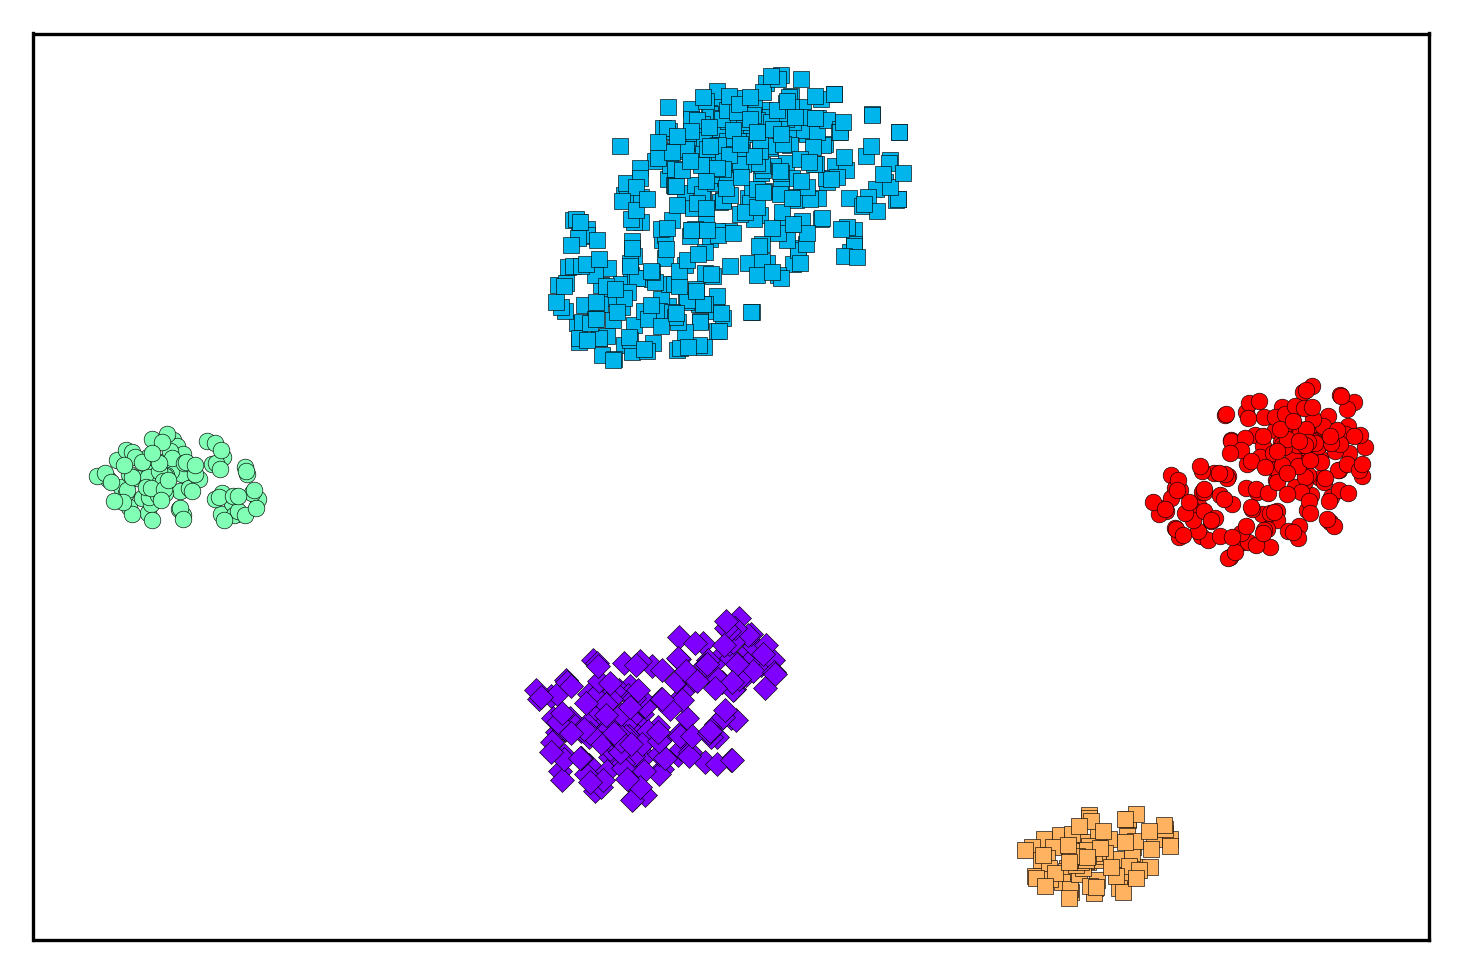

In [8]:
#Genertate latent embedding and visualization after clustering-training
Ynew = model.embedding(count, adj_n)
Y2new = dotsne(Ynew, dim=2)
myscatter(Y2new, idents)